<a href="https://colab.research.google.com/github/FarrahTharwat/Deep-Learning/blob/main/Copy_of_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
mydrive_path = '/content/drive/MyDrive/potato/Deep Project'
print(os.listdir(mydrive_path))

['Potato___healthy', 'Potato___Early_blight', 'Potato___Late_blight']


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from PIL import Image

In [ ]:
base_dir = "/content/drive/MyDrive/potato/Deep Project"
print(os.listdir(base_dir))

['Potato___healthy', 'Potato___Early_blight', 'Potato___Late_blight']


Unique labels before filtering: ['Potato___healthy' 'Potato___Early_blight' 'Potato___Late_blight']
Initial number of rows: 1490
Unique labels after filtering: ['Potato___healthy' 'Potato___Early_blight' 'Potato___Late_blight']
Number of rows after filtering: 1490
Training set size: 1043
Validation set size: 223
Test set size: 224
Found 1043 validated image filenames belonging to 3 classes.
Found 223 validated image filenames belonging to 3 classes.
Found 224 validated image filenames belonging to 3 classes.


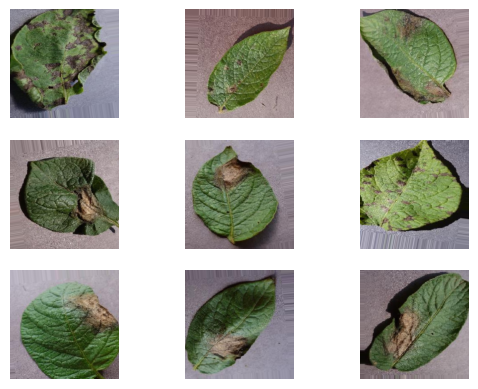

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

# Define constants
IMG_HEIGHT = 299  # Required image size for Xception
IMG_WIDTH = 299
BATCH_SIZE = 16

# Step 1: Create the DataFrame from the dataset directory
def create_dataframe(df_path):
    filepaths = []
    labels = []

    folds = os.listdir(df_path)

    for fold in folds:
        f_path = os.path.join(df_path, fold)
        imgs = os.listdir(f_path)

        for img in imgs:
            img_path = os.path.join(f_path, img)
            filepaths.append(img_path)
            labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    return pd.concat([fseries, lseries], axis=1)

# Define the classes to keep
classes_to_keep = [
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy'
]

# Step 2: Filter to include only the specified classes
df = create_dataframe('/content/drive/MyDrive/potato/Deep Project')

print(f"Unique labels before filtering: {df['Labels'].unique()}")
print(f"Initial number of rows: {len(df)}")

# Keep only the specified classes
df = df[df['Labels'].isin(classes_to_keep)]

print(f"Unique labels after filtering: {df['Labels'].unique()}")
print(f"Number of rows after filtering: {len(df)}")

# Step 3: Split the filtered DataFrame into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Labels'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Step 4: Define ImageDataGenerator for Xception data preprocessing
train_datagen = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Normalize images for Xception
)

# Step 5: Use flow_from_dataframe() for standard TensorFlow generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Visualize some training images
sample_images, sample_labels = next(train_generator)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((sample_images[i] + 1) / 2)  # Reverse normalization for visualization
    plt.axis('off')
plt.show()

In [ ]:
overlap_train_val = set(train_df['Filepaths']).intersection(set(val_df['Filepaths']))
overlap_val_test = set(val_df['Filepaths']).intersection(set(test_df['Filepaths']))
print(f"Train-Val overlap: {len(overlap_train_val)}")
print(f"Val-Test overlap: {len(overlap_val_test)}")


Train-Val overlap: 0
Val-Test overlap: 0


In [ ]:
# Step 6: Load the Xception base model (pre-trained on ImageNet)
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Step 7: Add custom layers for the PlantVillage classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.5)(x)              # Dropout for regularization
x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)  # Fully connected layer with L2 regularization
x = Dropout(0.5)(x)              # Dropout for regularization
predictions = Dense(len(classes_to_keep), activation='softmax')(x)  # Output layer

# Step 8: Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Step 9: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 673s 10s/step - accuracy: 0.6421 - loss: 13.6733 - val_accuracy: 0.8341 - val_loss: 11.1044 - learning_rate: 1.0000e-04
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 628s 9s/step - accuracy: 0.8217 - loss: 10.4996 - val_accuracy: 0.8924 - val_loss: 8.6396 - learning_rate: 1.0000e-04
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 625s 9s/step - accuracy: 0.8738 - loss: 8.1904 - val_accuracy: 0.9013 - val_loss: 6.8174 - learning_rate: 1.0000e-04
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 674s 9s/step - accuracy: 0.8920 - loss: 6.4739 - val_accuracy: 0.9372 - val_loss: 5.4056 - learning_rate: 1.0000e-04
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 659s 10s/step - accuracy: 0.9198 - loss: 5.1398 - val_accuracy: 0.9507 - val_loss: 4.3469 - learning_rate: 1.0000e-04
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 670s 10s/step - accuracy: 0.9286 - loss: 4.1719 - val_accuracy: 0.9507 - val_loss: 3.5516 - learning_rate: 1.0000e-04
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 629s 9s/step - accuracy: 0.9435 - los

In [ ]:
# Step 10: Fine-tune the model
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras import initializers

# Unfreeze the last 30 layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Regularization: Add Dropout Layer (if not already in the model)

dropout_layer = Dropout(0.5)  # Add a 50% dropout rate
x = dropout_layer(model.layers[-2].output)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=model.input, outputs=output)

# Recompile the model with adjustments
model.compile(
    # optimizer=Adam(learning_rate=0.00001),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# # Fine-tune the model with adjusted parameters
# history_finetune = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=10,
#     callbacks=[early_stopping, reduce_lr],  # Early stopping to monitor overfitting
#     verbose=1
# )



# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],  # Early stopping to monitor overfitting
    verbose=1

)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 814s 12s/step - accuracy: 0.5431 - loss: 2.6070 - val_accuracy: 0.6726 - val_loss: 2.3635 - learning_rate: 1.0000e-05
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 810s 12s/step - accuracy: 0.6734 - loss: 2.2992 - val_accuracy: 0.6771 - val_loss: 2.2683 - learning_rate: 1.0000e-05
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 815s 12s/step - accuracy: 0.7533 - loss: 2.1377 - val_accuracy: 0.7175 - val_loss: 2.1794 - learning_rate: 1.0000e-05


In [ ]:
# Step 11: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 12: Save the model
model.save('/content/xception_plantvillage.h5')

14/14 ━━━━━━━━━━━━━━━━━━━━ 99s 7s/step - accuracy: 0.6530 - loss: 2.3786


Test Loss: 2.3396835327148438
Test Accuracy: 0.6696428656578064


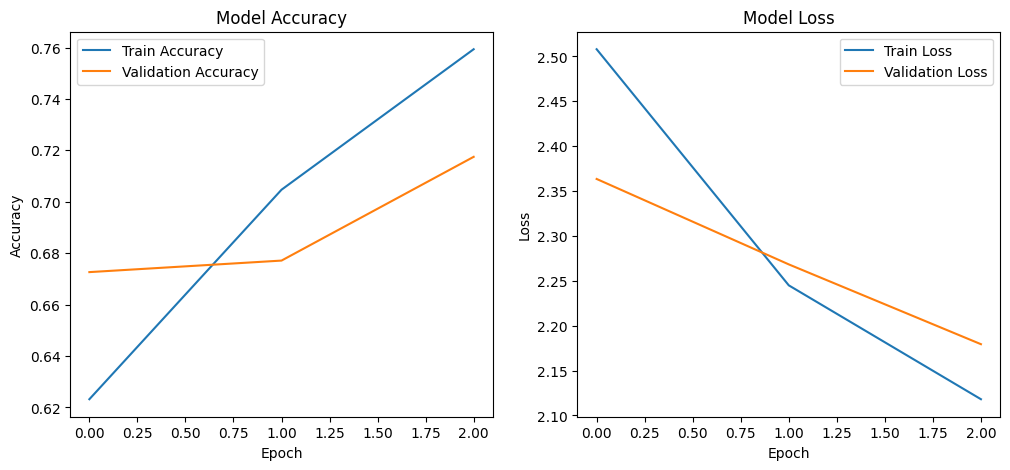

In [ ]:
# Plot training and validation accuracy/loss
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function
plot_accuracy_loss(history_finetune)


14/14 ━━━━━━━━━━━━━━━━━━━━ 98s 7s/step


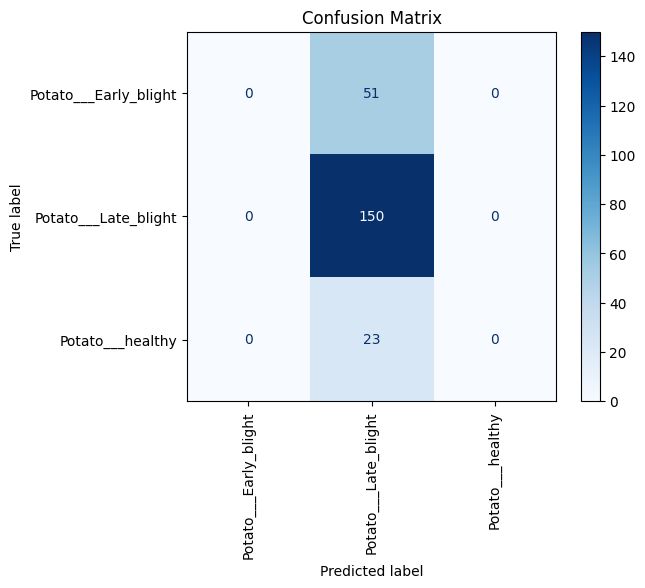

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the test set
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())  # Class names

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score     support
Potato___Early_blight   0.000000  0.000000  0.000000   51.000000
Potato___Late_blight    0.669643  1.000000  0.802139  150.000000
Potato___healthy        0.000000  0.000000  0.000000   23.000000
accuracy                0.669643  0.669643  0.669643    0.669643
macro avg               0.223214  0.333333  0.267380  224.000000
weighted avg            0.448422  0.669643  0.537147  224.000000


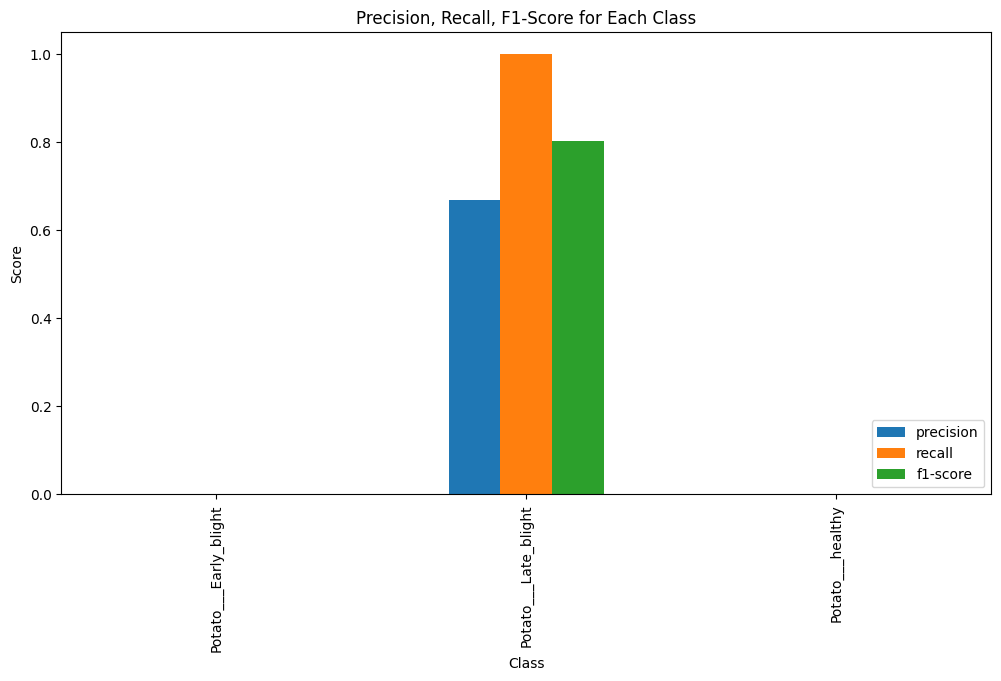

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

# Convert the classification report to a DataFrame for visualization
import pandas as pd
report_df = pd.DataFrame(report).transpose()

# Display the DataFrame
print(report_df)

# Plot Precision, Recall, and F1-Score
report_df.iloc[:-3, :-1].plot(kind='bar', figsize=(12, 6))  # Ignore support, avg/total rows
plt.title('Precision, Recall, F1-Score for Each Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.legend(loc='lower right')
plt.show()


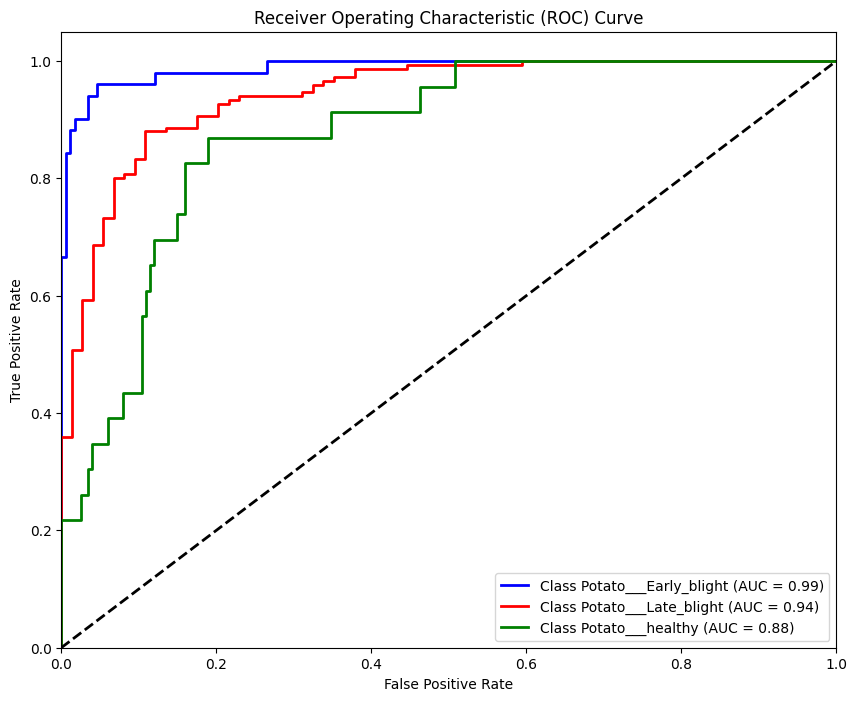

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# One-hot encode the true labels for multi-class ROC
y_true_one_hot = label_binarize(y_true, classes=list(range(len(labels))))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Compute macro-average AUC
macro_auc = roc_auc_score(y_true_one_hot, y_pred_probs, average='macro')
weighted_auc = roc_auc_score(y_true_one_hot, y_pred_probs, average='weighted')

print(f"Macro AUC: {macro_auc:.2f}")
print(f"Weighted AUC: {weighted_auc:.2f}")


Macro AUC: 0.94
Weighted AUC: 0.95
